In [1]:
using Random, PyPlot, Distributions

In [2]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

isi = 1/(fr*dt*1e-3) * randexp(Int(nt*1.5/fr), n_neurons)
spike_time = cumsum(isi, dims=1); # ISIを累積

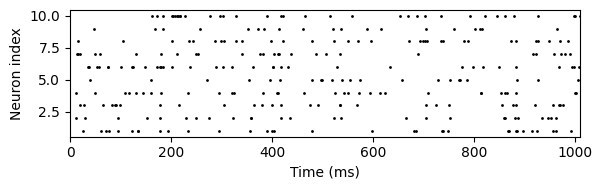

In [3]:
figure(figsize=(6, 2))
for i=1:n_neurons
    scatter(spike_time[:, i], i*ones(Int(nt*1.5/fr)), c="k", s=1)
end
xlabel("Time (ms)"); ylabel("Neuron index"); xlim(0, T+10); tight_layout()

In [4]:
spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
spike_time = round.(Int, spike_time) # float to int
spikes = zeros(nt, n_neurons) # スパイク記録変数

for i=1:n_neurons    
    spikes[spike_time[:, i], i] .= 1
end

spikes[1] = 0 # (spike_time=1)の発火を削除
println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 293.0
Firing rate : 29.3Hz


In [5]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 304
Firing rate : 30.4Hz


In [6]:
function rasterplot(spikes)
    # input spike -> time, #neurons
    spike_inds = Tuple.(findall(x -> x > 0, spikes))
    spike_time = first.(spike_inds)
    neuron_inds = last.(spike_inds)
    
    # raster plot
    scatter(spike_time, neuron_inds, s=1, c="black")
    xlabel("Time (ms)"); ylabel("Neuron index")
    tight_layout()
end

rasterplot (generic function with 1 method)

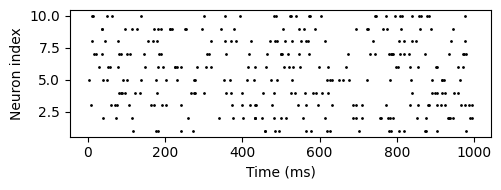

In [7]:
figure(figsize=(5,2))
rasterplot(spikes)

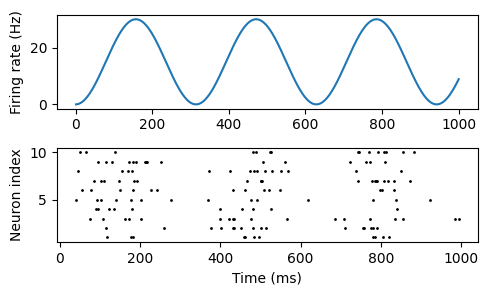

In [8]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = Int32(10) # ニューロンの数

t = Array{Float32}(1:nt)*dt
fr = 30(sin.(1e-2t)).^2 # ポアソンスパイクの発火率(Hz)

spikes = rand(nt, n_neurons) .< fr*dt*1e-3

figure(figsize=(5,3))
subplot(2,1,1); plot(t, fr); ylabel("Firing rate (Hz)")
subplot(2,1,2); rasterplot(spikes)

In [9]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps
tref = 5f0 # 不応期 (ms)

n_neurons = Int32(10) # ニューロンの数
fr = 30 # ポアソンスパイクの発火率(Hz)

tlast, spikes = zeros(n_neurons), zeros(nt, n_neurons) # 発火時刻の記録変数

# simulation
@time for i=1:nt
    fire = rand(n_neurons) .< fr*dt*1e-3
    spikes[i, :] = ((dt*i) .> (tlast .+ tref)) .* fire
    tlast[:] = tlast .* (1 .- fire) + dt*i * fire # 発火時刻の更新
end

println("Num. of spikes : ", sum(spikes))
println("Firing rate : ", sum(spikes)/(n_neurons*T)*1e3, "Hz")

  0.431056 seconds (1.66 M allocations: 92.045 MiB, 2.25% gc time, 98.95% compilation time)
Num. of spikes : 267.0
Firing rate : 26.700000000000003Hz


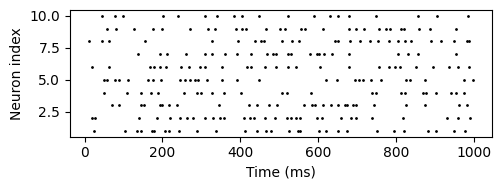

In [10]:
figure(figsize=(5,2))
rasterplot(spikes)

In [11]:
function GammaSpike(T, dt, n_neurons, fr, k)
    nt = Int32(T/dt) # number of timesteps
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)

    isi = rand(Gamma(k, theta), Int32(round(nt*1.5/fr)), n_neurons)
    spike_time = cumsum(isi, dims=1) # ISIを累積

    spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
    spike_time = round.(Int32, spike_time) # float to int
    spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

    for i=1:n_neurons    
        spikes[spike_time[:, i], i] .= 1
    end

    spikes[1] = 0 # (spike_time=1)の発火を削除
    return spikes
end

GammaSpike (generic function with 1 method)

In [12]:
Random.seed!(0) # set random seed

T = 1000 # ms
dt = 1f0 # ms
nt = Int32(T/dt) # number of timesteps

n_neurons = 10 # ニューロンの数
fr = 30 # ガンマスパイクの発火率(Hz)

# k=1のときはポアソン過程に一致
spikes1 = GammaSpike(T, dt, n_neurons, fr, 1)
spikes2 = GammaSpike(T, dt, n_neurons, fr, 12)

println("Num. of spikes : ", sum(spikes1), ", ",sum(spikes2))
println("Firing rate : ", sum(spikes1)/(n_neurons*T)*1e3, "Hz, ", sum(spikes2)/(n_neurons*T)*1e3, "Hz")

Num. of spikes : 289, 301
Firing rate : 28.9Hz, 30.099999999999998Hz


In [13]:
function GammaISIplot(dt, fr, k, n=1000)
    theta = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*theta)
    isi = rand(Gamma(k, theta), n)
    gamma_pdf = pdf.(Gamma(k, theta), minimum(isi):maximum(isi))

    hist(isi, bins=20, density=true, alpha=0.5, ec="black"); 
    plot(minimum(isi):maximum(isi), gamma_pdf, color="black"); 
    xlabel("ISI (ms)"); ylabel("Density");
end

GammaISIplot (generic function with 2 methods)

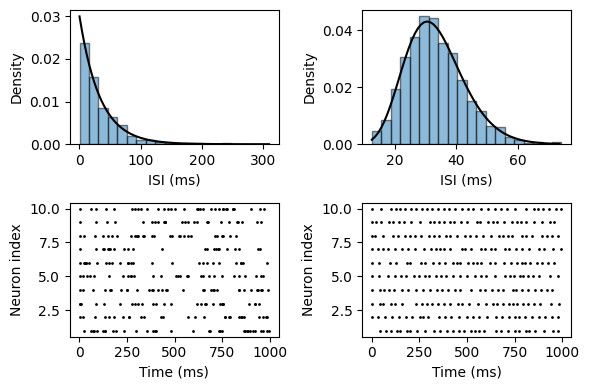

In [14]:
figure(figsize=(6, 4))
subplot(2,2,1); GammaISIplot(dt, fr, 1)
subplot(2,2,2); GammaISIplot(dt, fr, 12)
subplot(2,2,3); rasterplot(spikes1)
subplot(2,2,4); rasterplot(spikes2)
tight_layout()